In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from scipy import stats
from itertools import product
import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = (7,4)

In [19]:
data_customer = pd.read_csv("customers.tsv", sep="\t")
data_sales = pd.read_csv("sales.tsv", sep="\t")

In [20]:
data_sales["day"] = 1;
data_sales["date"] = pd.to_datetime(data_sales[["year", "month", "day"]]);

In [21]:
data_sales.head()

,year,month,location,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price,day,date
0,2017,1,Alpha City,AC,Chocolates,Cadbury,sku #79,1,Standart,No,Nothing,4572.0,NaN,1,2017-01-01
1,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #15,1,Standart,No,Nothing,8028.0,1.221336,1,2017-01-01
2,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #16,3,Standart,No,Nothing,6606.0,2.866401,1,2017-01-01
3,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #22,2,Standart,No,Nothing,11688.0,2.093719,1,2017-01-01
4,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #28,3,Standart,No,Nothing,3582.0,2.866401,1,2017-01-01


In [22]:
data_customer["day"] = 1;
data_customer["date"] = pd.to_datetime(data_customer[["year", "month", "day"]]);
data_customer_ac = data_customer[data_customer["ira"] == "AC"][["date", "amount_of_customers"]].groupby("date").sum()
data_customer_ac.head()

,amount_of_customers
date,
2017-01-01,54396.0
2017-02-01,54299.0
2017-03-01,65163.0
2017-04-01,73088.0
2017-05-01,76452.0


In [23]:
data_15_ac = data_sales[(data_sales["sku_id"] ==  "sku #79") & (data_sales["ira"] ==  "AC")][["date", "day", "year", "volume", "price"]]

In [24]:
data_15_ac["demand"] = data_customer_ac.values[:30]

In [25]:
data_15_ac.head()

,date,day,year,volume,price,demand
0,2017-01-01,1,2017,4572.0,NaN,54396.0
51,2017-02-01,1,2017,4800.0,NaN,54299.0
102,2017-03-01,1,2017,6594.0,NaN,65163.0
153,2017-04-01,1,2017,8010.0,NaN,73088.0
206,2017-05-01,1,2017,7950.0,NaN,76452.0


#### Спрос не нужно было прогнозировать,  эх

#### Руками подбирать параметры для 160 моделей - не самая лучшая идея. Это задача массового прогнозирования. 
#### Методы: XGBoost, линейная регрессия с регуляризаторами + сезонностью 

## <center> Прогнозирование с SARIMAX
   

In [26]:
dataX = data_15_ac[["date", "volume", "demand"]]

In [27]:
dataX = dataX.set_index("date")

In [28]:
dataX.head()

,volume,demand
date,,
2017-01-01,4572.0,54396.0
2017-02-01,4800.0,54299.0
2017-03-01,6594.0,65163.0
2017-04-01,8010.0,73088.0
2017-05-01,7950.0,76452.0


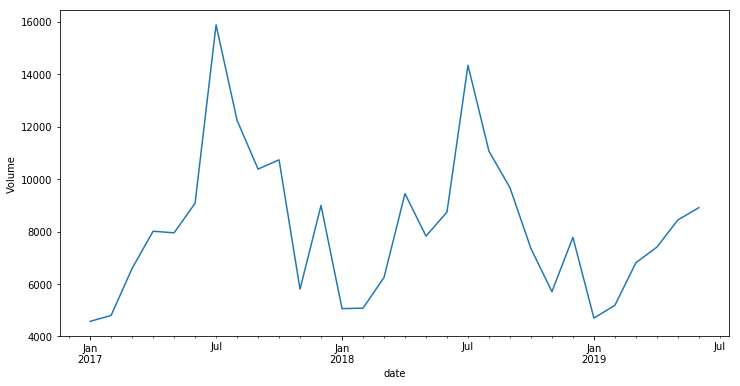

In [29]:
plt.rcParams['figure.figsize'] = (12,6)
dataX.volume.plot()
plt.ylabel('Volume')
plt.show()

Критерий Дики-Фуллера: p=0.000038


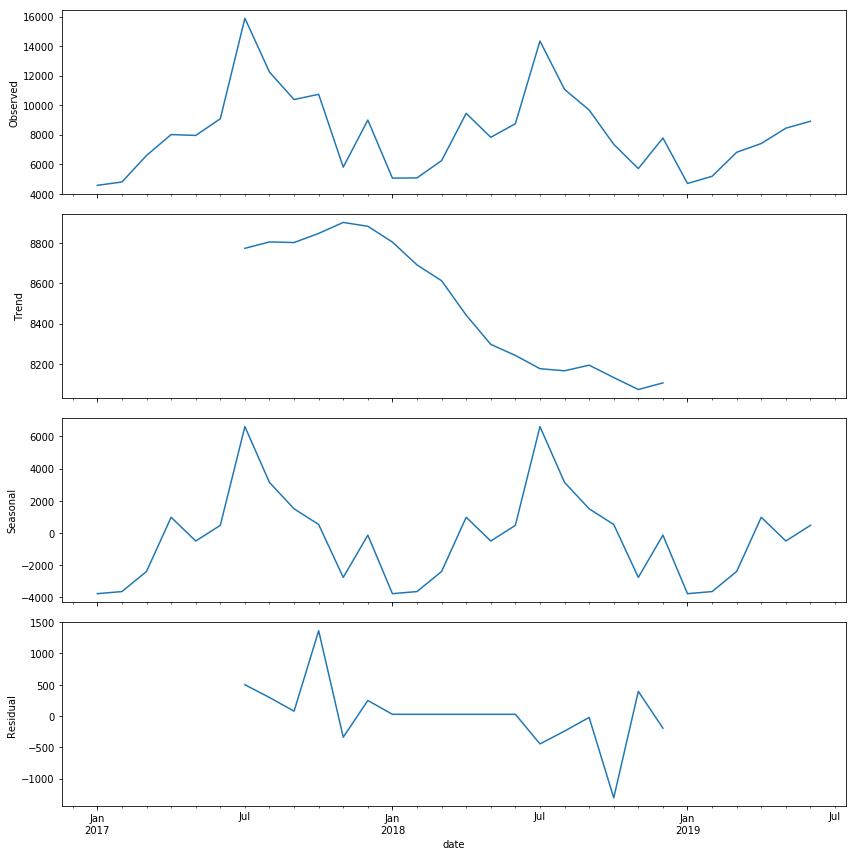

In [30]:
plt.rcParams['figure.figsize'] = (12,12)
sm.tsa.seasonal_decompose(dataX.volume).plot()
print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(dataX.volume)[1])

По критерию Дики-Фуллера он стационарен, значит можно использовать ARIMA


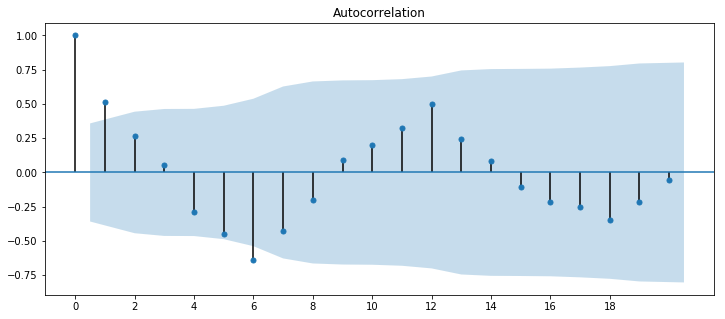

In [16]:
plt.rcParams['figure.figsize'] = (12,5)
sm.graphics.tsa.plot_acf(dataX.volume, lags=20)
plt.xticks(np.arange(0, 20, 2.0))
plt.show()

In [31]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [32]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [33]:
import warnings; warnings.simplefilter('ignore')

In [34]:
%%time
results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(dataX.volume, dataX.demand, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 6)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

wrong parameters: (0, 0, 4, 0)
wrong parameters: (0, 1, 4, 0)
wrong parameters: (0, 2, 4, 0)
wrong parameters: (0, 3, 4, 0)
wrong parameters: (1, 0, 4, 0)
wrong parameters: (1, 1, 4, 0)
wrong parameters: (1, 2, 4, 0)
wrong parameters: (1, 3, 4, 0)
wrong parameters: (2, 0, 4, 0)
wrong parameters: (2, 1, 4, 0)
wrong parameters: (2, 2, 4, 0)
wrong parameters: (2, 3, 4, 0)
wrong parameters: (3, 0, 4, 0)
wrong parameters: (3, 1, 4, 0)
wrong parameters: (3, 2, 4, 0)
wrong parameters: (3, 3, 4, 0)
wrong parameters: (4, 0, 4, 0)
wrong parameters: (4, 1, 4, 0)
wrong parameters: (4, 2, 4, 0)
wrong parameters: (4, 3, 4, 0)
CPU times: user 1min 51s, sys: 2min 3s, total: 3min 54s
Wall time: 1min 1s


In [39]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
5   (0, 1, 1, 0)  381.967607
9   (0, 2, 1, 0)  383.496772
21  (1, 1, 1, 0)  383.547248
6   (0, 1, 2, 0)  383.967410
13  (0, 3, 1, 0)  385.476918


In [40]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                            volume   No. Observations:                   30
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 6)   Log Likelihood                -186.984
Date:                           Mon, 21 Oct 2019   AIC                            381.968
Time:                                   01:49:30   BIC                            386.510
Sample:                               01-01-2017   HQIC                           383.110
                                    - 06-01-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
demand         0.1931      0.023      8.254      0.000       0.147       0.239
ma.L1         -0.9949      0.248     -4.005

Критерий Стьюдента: p=0.535536
Критерий Дики-Фуллера: p=0.000008


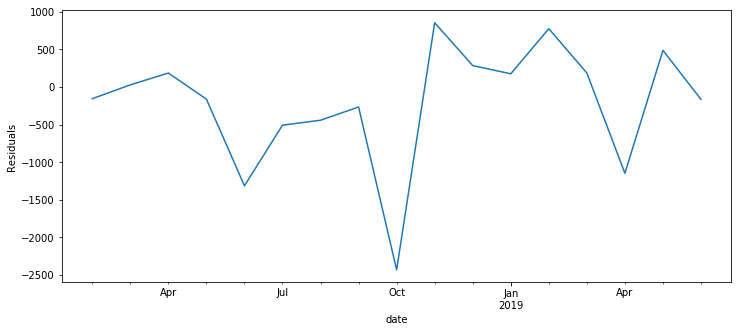

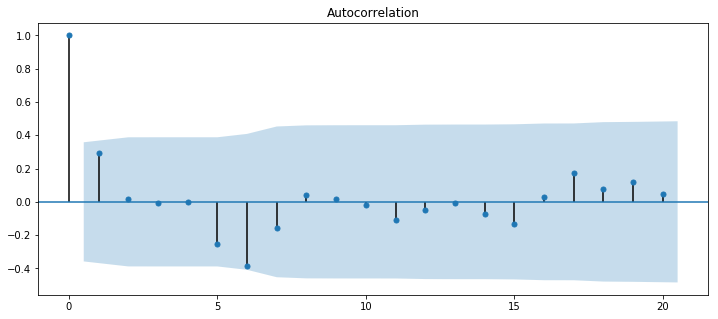

In [41]:
plt.rcParams['figure.figsize'] = (12,5)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

sm.graphics.tsa.plot_acf(best_model.resid, lags=20)

print('Критерий Стьюдента: p=%f' % stats.ttest_1samp(best_model.resid, 0)[1])
print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(best_model.resid)[1])

plt.show()

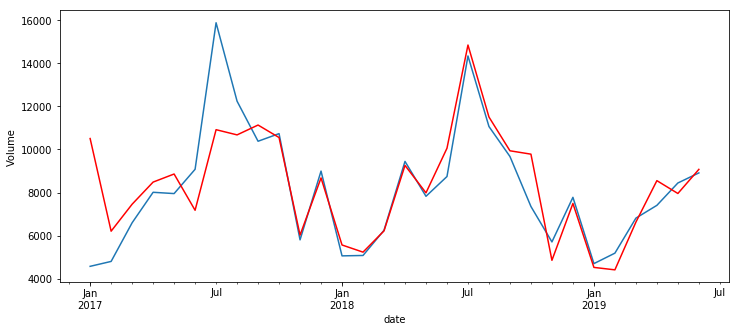

In [42]:
dataX['model'] = best_model.fittedvalues
dataX.volume.plot()
dataX.model.plot(color='r')
plt.ylabel('Volume')
plt.show()